# Neural Power Amplifier - Example Usage
## 1. Load some data

In [1]:
%matplotlib inline
import mne
from mne.datasets import spm_face

import matplotlib.pyplot as plt

data_path = spm_face.data_path()

fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds'

eeg = mne.io.read_raw_ctf(fname)

picks = mne.pick_types(eeg.info, meg=False, eeg=True, stim=False, include=['STI 014'])

ds directory : C:\Users\doyle\mne_data\MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -0.90   72.01    0.00 mm <->   -0.90   72.01    0.00 mm (orig :  -43.09   61.46 -252.17 mm) diff =    0.000 mm
       0.90  -72.01    0.00 mm <->    0.90  -72.01    0.00 mm (orig :   53.49  -45.24 -258.02 mm) diff =    0.000 mm
      98.30    0.00    0.00 mm <->   98.30   -0.00    0.00 mm (orig :   78.60   72.16 -241.87 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for C:\Users\doyle\mne_data\MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds\SPM_CTF_MEG_example_faces1_3D.meg4: 
    System clock channel is available, checking which samples are valid.
    1 x 324474 = 324474 samples from 340 

## 2. Estimate FOOOF model

Effective window size : 0.533 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.0s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.6s finished



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 45 Hz                        
                                 Frequency Resolution is 1.88 Hz                                  
                                                                                                  
                          Background Parameters (offset, knee, slope):                            
                                     -26.1021, 0.1151, 1.3269                                     
                                                                                                  
                             

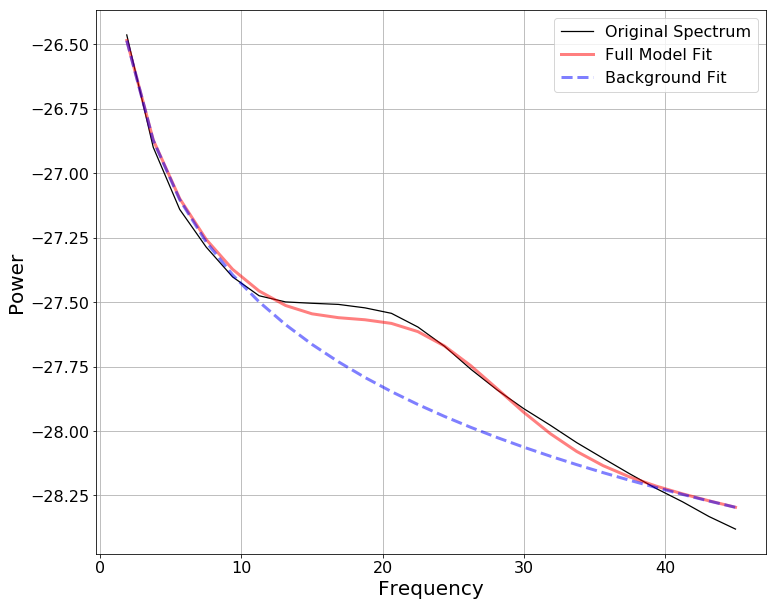

In [2]:
from mne.time_frequency import psd_welch
import numpy as np
import fooof

orig_psds, orig_freqs = psd_welch(eeg, 0, 45, n_jobs=-1)

ff = fooof.FOOOF(min_peak_amplitude=0.01, peak_width_limits=[3, 20], background_mode='knee')
ff.fit(orig_freqs, np.mean(orig_psds, axis=0), freq_range=[0, 45])
ff.report()

## 3. Apply Neural Power Amplifier

No handles with labels found to put in legend.


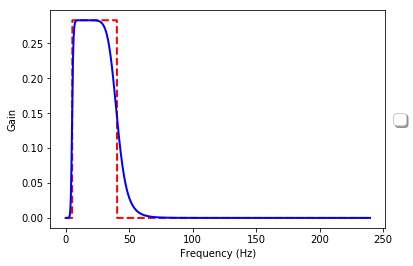

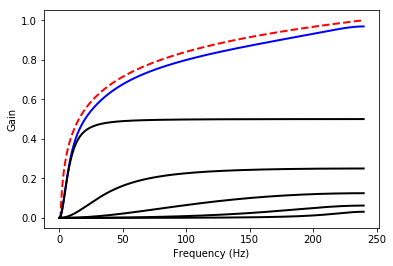

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  29 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  14 out of  29 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  29 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  14 out of  29 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of  29 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  14 out of  29 | elapsed:

Creating RawArray with float64 data, n_channels=29, n_times=324474
    Range : 0 ... 324473 =      0.000 ...   675.985 secs
Ready.
Effective window size : 0.533 (s)


[Parallel(n_jobs=8)]: Done  29 out of  29 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


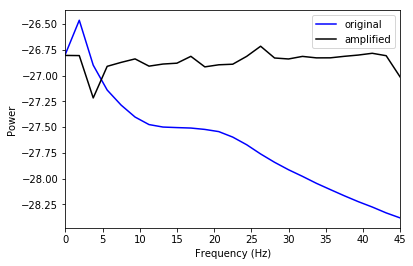

In [3]:
from npa import NPA
from scipy.signal import welch

amp = NPA(ff, eeg.info['sfreq'])
amp.fit_filters()

amp.plot_peak_filters()
amp.plot_log_filters()

amplified_time_series = amp.amplify(eeg.get_data(picks=picks))
# create new MNE Raw object with amplified EEG signal
eeg_ch_names = [eeg.ch_names[i] for i in picks]
amp_info = mne.create_info(eeg_ch_names, eeg.info['sfreq'], ch_types='eeg')
amplified_eeg = mne.io.RawArray(np.float64(amplified_time_series), amp_info)

# calculate and plot PSD
amp_psds, amp_freqs = psd_welch(amplified_eeg, 0, 45, n_jobs=-1)

plt.plot(orig_freqs, np.log10(np.mean(orig_psds, axis=0)), color='blue', label='original')
plt.plot(amp_freqs, np.log10(np.mean(amp_psds, axis=0)), color='black', label='amplified')

plt.xlim([0, 45])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.show()